# Ternary Multiplication in Triton

## Setup

Check the installed triton version.

In [1]:
import triton

assert triton.__version__ == "3.0.0"

Import other needed stuff.

In [2]:
import torch
import triton.language as tl

## Helper Functions

In [3]:
def get_current_target():
    return triton.runtime.driver.active.get_current_target()

In [4]:
import warnings


def is_cuda():
    current_target = get_current_target()
    if current_target.backend != "cuda":
        return False

    if current_target.arch < 70:  # CUDA compute capacity is below 7.0, which is minimum 'stable' supported by Triton
        warnings.warn(
            "Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!", stacklevel=1
        )

    return True

In [5]:
def get_cuda_autotune_config():
    return [
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 64,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 32,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 32,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 32,
            },
            num_stages=5,
            num_warps=2,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 32,
                "BLOCK_SIZE_N": 64,
            },
            num_stages=5,
            num_warps=2,
        ),
    ]

In [6]:
def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    else:
        raise ValueError("Not on CUDA... can't use!")

Main ternary multiplication kernel.

The rough pseudocode algorithm is as follows.
```python
# Do in parallel
for n in range(0, N, BLOCK_SIZE_N):
    acc = zeros((BLOCK_SIZE_N,), dtype=float32)
    for m in range(0, M, BLOCK_SIZE_M):
        x_block = x[m : m+BLOCK_SIZE_M]
        w_block = w[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N]
        
        # Since `w` is ternary, we only really care about the sign of the element in the array, and so
        # we just need to perform two conditional checks
        elems_to_sum = tl.where(w_block > 0, x_block, tl.where(w_block < 0, -x_block, tl.zeros_like(x_block)))
        acc += tl.sum(elems_to_sum)  # Sum along the M direction

    acc = acc / scale
    z[n : n+BLOCK_SIZE_N] = acc
```

In [7]:
# ruff: noqa: N803, PLR2044
@triton.autotune(
    configs=get_autotune_config(),
    key=["M", "N"],
)
@triton.jit
def ternary_mul_kernel(
    # Pointers to matrices
    x_ptr,
    w_ptr,
    z_ptr,
    # Scaling factor
    scale,
    # `W` matrix dimensions
    M,
    N,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_xm,
    stride_wm,
    stride_wn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    """
    Kernel for computing the ternary multiplication
        z = xW
    `x` has shape `(1, M)`, `W` has shape `(M, N)`, and `z` has shape `(1, N)`.
    """

    # -----------------------------------------------------------
    # Map `pid` to the block of `z` that it should compute.
    pid = tl.program_id(axis=0)

    # ----------------------------------------------------------
    # Create pointers for the first blocks of `x` and `W`.
    # We will advance this pointer as we move in the `M` direction and accumulate.
    # - `x_ptrs` is a block of `BLOCK_SIZE_M` pointers
    # - `w_ptrs` is a block of pointers with shape `(BLOCK_SIZE_M, BLOCK_SIZE_N)`
    offs_m = tl.arange(0, BLOCK_SIZE_M)
    offs_n = (pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets
    x_ptrs = x_ptr + offs_m
    w_ptrs = w_ptr + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the `z` vector.
    # We accumulate into a block of `BLOCK_SIZE_N` elements of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)
    for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
        # Load the next block of `x` and `W`, generate a mask by checking along `M`.
        # If it is out of bounds, set it to 0.
        x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
        w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

        # Since `w` is ternary, we only really care about the sign of the element in the array, and so
        # we just need to perform two conditional checks
        elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
        accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

        # Advance the ptrs to the next `M` block.
        x_ptrs += BLOCK_SIZE_M * stride_xm
        w_ptrs += BLOCK_SIZE_M * stride_wm

    accumulator = accumulator / scale
    z = accumulator  # TODO: Do we want to reduce to FP16?

    # -----------------------------------------------------------
    # Write back the block of the output vector `z` with masks.
    offs_z = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    z_ptrs = z_ptr + offs_z
    z_mask = offs_z < N
    tl.store(z_ptrs, z, mask=z_mask)

/tmp/ipykernel_37697/1541291054.py:10: UserWarning: Compute capcity of CUDA device is below 7.0. The Triton compilation may fail terribly!
  warnings.warn("Compute capcity of CUDA device is below 7.0. The Triton compilation may fail terribly!")


We can now create a convenience wrapper function that only takes two input tensors, and (1) checks any shape constraint; (2) allocates the output; (3) launches the above kernel.

In [8]:
# ruff: noqa: E731, S101, N806
def ternary_mul(x, w, scale):
    # Check constraints
    assert len(x) == w.shape[0], "Incompatible dimensions"
    assert x.is_contiguous(), "x must be contiguous"

    assert x.is_cuda and w.is_cuda

    # Get dimensions
    M, N = w.shape

    # Allocate output
    z = torch.empty((N,), device=x.device, dtype=torch.float32)  # TODO: Change precision?

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]),)

    # fmt: off
    ternary_mul_kernel[grid](
        x, w, z,
        scale,
        M, N,
        x.stride(0),
        w.stride(0), w.stride(1)
    )
    # fmt: on

    return z

TESTING CODE

In [9]:
X_LEN = 256  # x is the 1D vector
W_LEN = 256  # W is the quantized weights matrix
W_SIZE = (X_LEN, W_LEN)

In [10]:
torch.manual_seed(8192)

In [11]:
x = torch.rand(X_LEN, device="cuda", dtype=torch.float32)
w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SIZE)]
scale = torch.rand(1, dtype=torch.float32).item()

In [12]:
torch_output = torch.matmul(x, w) / scale
torch_output

tensor([-951.4594, -810.9307, -814.1393, -753.9046, -771.3155, -788.1216,
        -772.3747, -750.3213, -766.9465, -775.3512, -796.5271, -740.3124,
        -743.4036, -764.6676, -699.1962, -728.9562, -786.4343, -858.7490,
        -760.0906, -839.8545, -789.4946, -795.4908, -754.4786, -771.1029,
        -783.6049, -834.9073, -931.8519, -694.6861, -695.2032, -707.0848,
        -848.7382, -729.0391, -769.3309, -748.5757, -834.0535, -869.5665,
        -803.8021, -884.6586, -680.9594, -903.9478, -761.8308, -839.1580,
        -803.7127, -718.6333, -751.7179, -751.2381, -769.1642, -787.6885,
        -768.6287, -815.1701, -668.5592, -739.2564, -811.2242, -763.2260,
        -832.9089, -802.8115, -761.8378, -714.6352, -771.6232, -756.2714,
        -863.0844, -838.2726, -721.9910, -765.3901, -799.4003, -860.3110,
        -921.7515, -778.2712, -853.6852, -721.2637, -808.6849, -811.3694,
        -699.9083, -809.1854, -914.3477, -809.1392, -791.8344, -796.9955,
        -751.8312, -731.2245, -900.767

In [13]:
triton_output = ternary_mul(x, w, scale)
triton_output

tensor([-951.4592, -810.9307, -814.1393, -753.9047, -771.3155, -788.1217,
        -772.3747, -750.3212, -766.9465, -775.3511, -796.5271, -740.3126,
        -743.4036, -764.6675, -699.1962, -728.9562, -786.4343, -858.7490,
        -760.0906, -839.8545, -789.4948, -795.4908, -754.4785, -771.1029,
        -783.6047, -834.9072, -931.8519, -694.6860, -695.2033, -707.0848,
        -848.7383, -729.0392, -769.3309, -748.5757, -834.0536, -869.5665,
        -803.8021, -884.6586, -680.9593, -903.9476, -761.8307, -839.1580,
        -803.7127, -718.6334, -751.7179, -751.2381, -769.1642, -787.6886,
        -768.6287, -815.1701, -668.5591, -739.2564, -811.2243, -763.2259,
        -832.9091, -802.8115, -761.8378, -714.6352, -771.6231, -756.2714,
        -863.0844, -838.2726, -721.9910, -765.3901, -799.4003, -860.3109,
        -921.7516, -778.2714, -853.6852, -721.2637, -808.6850, -811.3694,
        -699.9083, -809.1855, -914.3478, -809.1391, -791.8344, -796.9955,
        -751.8312, -731.2245, -900.767

In [14]:
if torch.allclose(triton_output, torch_output, atol=1e-3):
    print("✅ Triton and Torch match")
else:
    raise ValueError("❌ Triton and Torch differ")

✅ Triton and Torch match


BENCHMARK CODE

Trial when M =  128 for cublas
Trial when M =  128 for triton
Trial when M =  256 for cublas
Trial when M =  256 for triton
Trial when M =  384 for cublas
Trial when M =  384 for triton
Trial when M =  512 for cublas
Trial when M =  512 for triton
Trial when M =  640 for cublas
Trial when M =  640 for triton
Trial when M =  768 for cublas
Trial when M =  768 for triton
Trial when M =  896 for cublas
Trial when M =  896 for triton
Trial when M =  1024 for cublas
Trial when M =  1024 for triton
Trial when M =  1152 for cublas
Trial when M =  1152 for triton
Trial when M =  1280 for cublas
Trial when M =  1280 for triton
Trial when M =  1408 for cublas
Trial when M =  1408 for triton
Trial when M =  1536 for cublas
Trial when M =  1536 for triton
Trial when M =  1664 for cublas
Trial when M =  1664 for triton
Trial when M =  1792 for cublas
Trial when M =  1792 for triton
Trial when M =  1920 for cublas
Trial when M =  1920 for triton
Trial when M =  2048 for cublas
Trial when M =  2048 f

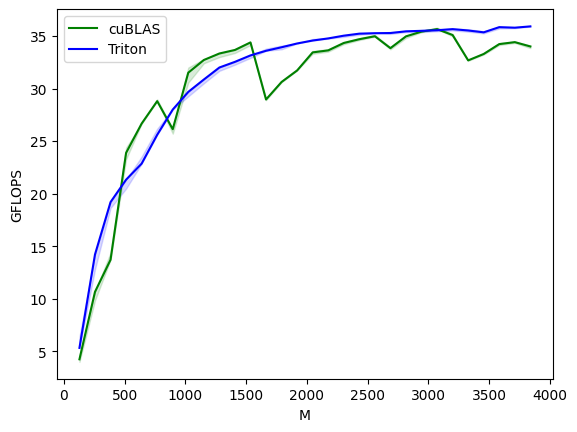

ternary-mul-performance:
         M       N     cuBLAS     Triton
0    128.0   128.0   4.248963   5.333333
1    256.0   256.0  10.666666  14.222222
2    384.0   384.0  13.714286  19.200000
3    512.0   512.0  23.883382  21.333333
4    640.0   640.0  26.666667  22.857142
5    768.0   768.0  28.800001  25.600000
6    896.0   896.0  26.133334  28.000000
7   1024.0  1024.0  31.507692  29.681159
8   1152.0  1152.0  32.713073  30.857143
9   1280.0  1280.0  33.333332  32.000001
10  1408.0  1408.0  33.669564  32.537816
11  1536.0  1536.0  34.388059  33.151080
12  1664.0  1664.0  28.958501  33.590061
13  1792.0  1792.0  30.623131  33.925626
14  1920.0  1920.0  31.718062  34.285715
15  2048.0  2048.0  33.436734  34.565401
16  2176.0  2176.0  33.629091  34.766919
17  2304.0  2304.0  34.331126  35.027026
18  2432.0  2432.0  34.690690  35.219513
19  2560.0  2560.0  34.972678  35.261708
20  2688.0  2688.0  33.841726  35.280001
21  2816.0  2816.0  34.961626  35.441647
22  2944.0  2944.0  35.414226  3

In [15]:
ref_lib = "cuBLAS"

configs = [
    triton.testing.Benchmark(
        x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 31)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GFLOPS",  # Label name for the y-axis
        plot_name="ternary-mul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
]


@triton.testing.perf_report(configs)
def benchmark(M, N, provider):
    print("Trial when M = ", M, "for", provider)
    x = torch.rand(M, device="cuda")
    w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (M, N))]
    scale = 0.5

    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, w) / scale, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul(x, w, scale), quantiles=quantiles)
    gflops = lambda ms: 2 * M * N * 1e-9 / (ms * 1e-3)
    return gflops(ms), gflops(max_ms), gflops(min_ms)


benchmark.run(show_plots=True, print_data=True)